In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

In [2]:
df1 = pd.read_csv('../data/processed_data/merged_characteristics.csv')
df2 = pd.read_csv('../data/processed_data/merged_characteristics_2017.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']


missing_cols = ['DP05_0028PE', 'Number of Consumers with CSR AV of 87%', 
                'Average Monthly Advanced CSR Payment for Consumers with 87%', 
                'DP05_0018PE', 'Number of Consumers with CSR (AV of 73%/87%/94%)', 'Total Number of Consumers',
                'Number of Consumers with CSR AV of 73%', 'Number of Consumers with CSR AV of 94%', 'FIPS County Code',
                'Average Monthly Advanced CSR Payment for Consumers with 73%', 
                'Average Monthly Advanced CSR Payment for Consumers with 94%', 
                'DP05_0032PE', 'DP05_0004PE', 'County Name']




#setup y
y_cols = ['Ever Enrolled Count']
    
x_cols = []
for col in df1.columns:
    if col not in y_cols and col not in keys and col not in missing_cols and not 'StateCode' in col and not 'IssuerId' in col: 
        x_cols.append(col)

print(df1['Ever Enrolled Count'].var())

22747104.27037359


In [3]:
X_train = df1[x_cols]
X_train = X_train/X_train.std()

X_test = df2[x_cols]
X_test = X_test/X_test.std()
X_test = X_test.fillna(0)

y_train = df1[y_cols]
y_test = df2[y_cols]

In [4]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,y_test):
    #setup the data
    
    plt.hist(y_pred[y_test < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_test < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_pred > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()
    
    
def plot_importance(X_test,model):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()

    
def report_error(y_test,y_pred):
    y_test = y_test.copy()
    y_test['error'] = np.abs(y_test - y_pred)**2
    y_test['pred'] = y_pred
    result = y_test.merge(df2, how='inner',left_index=True, right_index=True,suffixes=('','_x'))
    result  =  result.rename(columns={'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94',
                                     'EHBPercentTotalPremium':'prices'})
    result['shares'] = result['Ever Enrolled Count']/result['DP03_0095E']
    result = result.sort_values('error',ascending=False).head(50)
    #plt.title('20 worst predictions')
    #plt.hist(result['Ever Enrolled Count'],label='true',alpha=.5,density=True)
    #plt.hist(result['pred'],label='pred',alpha=.5,density=True)
    #plt.legend()
    #plt.show()
    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    #MetalLevel_Silver
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

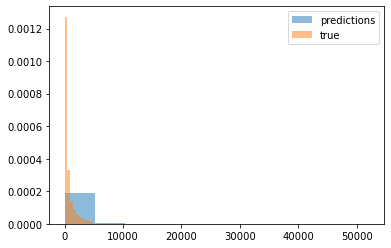

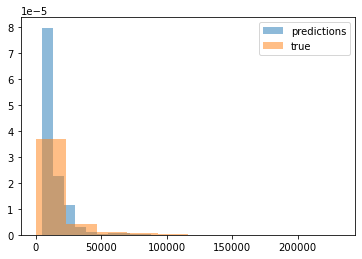

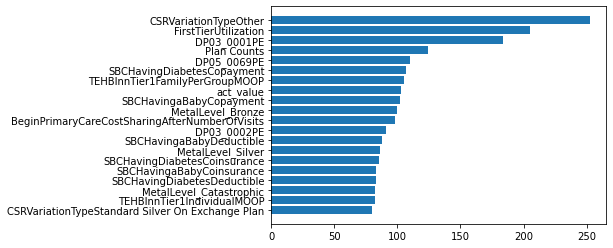

mse 18885171.579254087 r2 0.5088409470468354 var 38450215.80220148
pred 2016 9857980.0 actual 2016 9870266.0
pred mean 2016 1121.8823 mean 2016 1123.2805280528053
pred 2017 9344572.0 actual 2017 9167801.0
pred mean 2017 1639.9739990234375 actual 2017 1608.9506844506845


In [5]:
params = [(5,.1,.5,.5)]


for param in params:
    mses = []
    r2s = []
    np.random.seed(3)
    # not super deep, but uses most of the data at one
    model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=param[0],
                         eta=param[1], subsample=param[2], colsample_bytree=param[3])
    model.fit(X_train, y_train)

    y_pred = get_predictions(model,X_test)
    mse = float( ((y_test - y_pred)**2).mean() )
    r2 = float(  1- mse/y_test.var() )

    #plot the difference between true and predicted
    split = 5000
    plot_prediction(split,y_pred,y_test)
    plot_importance(X_test,model)
            
    #report fit statistics
    mses,r2s = np.array(mses),np.array(r2s)
    print( 'mse', mse ,'r2', 1 - float(mse/y_test.var()), 'var', float(y_test.var()) )
    
    print( 'pred 2016', get_predictions(model,X_train).sum(),
          'actual 2016', float(y_train.sum()))
    print( 'pred mean 2016', get_predictions(model,X_train).mean(),
          'mean 2016', float(y_train.mean()))
    
    print('pred 2017', float(y_pred.sum()), 'actual 2017', float(y_test.sum()))
    print('pred mean 2017', float(y_pred.mean()), 'actual 2017', float(y_test.mean()))

mse 26252767.20233316 r2 0.3172270517964154 var 38450215.80220148
pred 2016 9857980.0 actual 2016 9870266.0
pred mean 2016 1121.8823 mean 2016 1123.2805280528053
pred 2017 8804411.154931014 actual 2017 9167801.0
pred mean 2017 1545.175702866096 mean 2017 1608.9506844506845


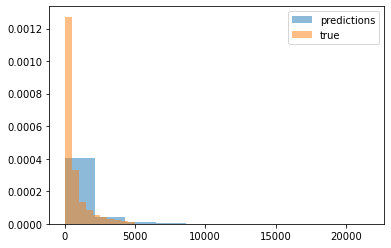

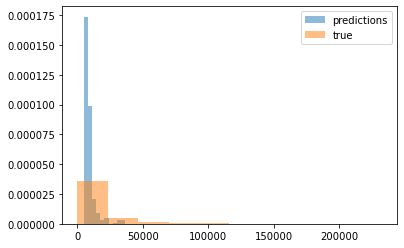

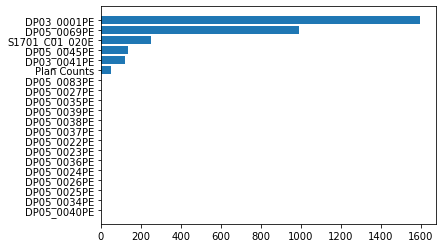

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
AZ     28584.590040        102128.000000           NaN           NaN
IL     22238.617967         53300.500000  20133.930739  32616.714496
NV     16991.188051         47506.000000           NaN           NaN
TX     15682.778563         57073.888889   9864.898977  34834.845153
FL     12671.122177         59422.312500   6135.696358  52695.556914
VA      9678.332691         35581.000000           NaN           NaN
PA      7774.894964         33730.000000   2962.209647   8895.247308
UT      7621.525097         32160.333333   3079.338732   7605.002980
GA      7123.240141         34179.750000   1162.841609  12126.440901
NC      6900.492367         46566.333333   2249.577702  18071.783872
MO      6614.493951         33361.000000           NaN           NaN
0       6053.542234         27254.500000   3026.518112   2519.421461
OK      5712.016752         29752.

In [6]:
# Vary alpha values
a = [250]
for i in a: 
    lasso = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
    y_pred = get_predictions(lasso,np.array(X_test))
    
    mse = float(((y_test - y_pred)**2).mean())
    r2 = float( 1 - mse/y_test.var() )
    print( 'mse', mse ,'r2', 1 - float(mse/y_test.var()), 'var', float(y_test.var()) )
    
    print( 'pred 2016', get_predictions(model,X_train).sum(),
          'actual 2016', float(y_train.sum()))
    print( 'pred mean 2016', get_predictions(model,X_train).mean(),
          'mean 2016', float(y_train.mean()))
    
    print('pred 2017', float(y_pred.sum()), 'actual 2017', float(y_test.sum()))
    print('pred mean 2017', float(y_pred.mean()), 'mean 2017', float(y_test.mean()))
    #plot the difference between true and predicted
    split = 5000
    plot_prediction(split,y_pred,y_test)
    
    #also plot important feature
    param_df = pd.DataFrame(np.abs(lasso.params),columns=['score']).sort_values(by=['score'], ascending=False).head(20)
    param_df['features'] = param_df.index
    plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
    plt.show()
    print(report_error(y_test,y_pred))
    print('==========================================')
    print('==========================================')